Here I am building a Multi-class Classification using LSTM on the public data available [here](https://data.consumerfinance.gov/api/views/s6ew-h6mp/rows.csv?accessType=DOWNLOAD)  we will use the  Product and consumer review columns for classification

In [0]:
!wget -O Consumer_Complaints.csv https://data.consumerfinance.gov/api/views/s6ew-h6mp/rows.csv?accessType=DOWNLOAD

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.plotly as py
from plotly.offline import iplot
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [0]:
data=pd.read_csv("rows.csv?accessType=DOWNLOAD",engine="python" ,encoding='utf-8', error_bad_lines=False)

In [4]:
data.shape
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1298835 entries, 0 to 1298834
Data columns (total 18 columns):
Date received                   1298835 non-null object
Product                         1298835 non-null object
Sub-product                     1063669 non-null object
Issue                           1298835 non-null object
Sub-issue                       765598 non-null object
Consumer complaint narrative    384314 non-null object
Company public response         458244 non-null object
Company                         1298835 non-null object
State                           1278830 non-null object
ZIP code                        1181648 non-null object
Tags                            177850 non-null object
Consumer consent provided?      697709 non-null object
Submitted via                   1298835 non-null object
Date sent to company            1298835 non-null object
Company response to consumer    1298828 non-null object
Timely response?                1298835 non-null obj

In [0]:
col=["Product","Consumer complaint narrative"]
data=data[col]
data = data[pd.notnull(data['Consumer complaint narrative'])]

In [6]:
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    92707
Debt collection                                                                 86870
Mortgage                                                                        53067
Credit reporting                                                                31588
Student loan                                                                    21842
Credit card or prepaid card                                                     21443
Credit card                                                                     18838
Bank account or service                                                         14885
Checking or savings account                                                     12906
Consumer Loan                                                                    9474
Vehicle loan or lease                                                            5766
Money transfer, virtual currency, or money service    

1. Consolidate “Credit reporting” into “Credit reporting, credit repair services, or other personal consumer reports”.
2. Consolidate “Credit card” into “Credit card or prepaid card”.
3. Consolidate “Payday loan” into “Payday loan, title loan, or personal loan”.
4. Consolidate “Virtual currency” into “Money transfer, virtual currency, or money service”.
5. “Other financial service” has very few number of complaints and it does not mean anything, so, I decide to remove it.

In [0]:
data.loc[data['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
data.loc[data['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
data.loc[data['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
data.loc[data['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
data = data[data.Product != 'Other financial service']

In [0]:
plt.figure(figsize=(8,8))
data['Product'].value_counts().sort_values(ascending=False).plot(kind='bar',  
                                                                title='Number complaints in each product')

In [20]:
data=data.reset_index()
data=data[col]
data.head()

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",reached credit bureaus one seem resolve issue...
1,"Credit reporting, credit repair services, or o...",victim identity theft. personal information co...
2,"Credit reporting, credit repair services, or o...",victim identity theft. personal information co...
3,"Credit reporting, credit repair services, or o...",credit agencies accounts mine listed mine. vic...
4,"Credit reporting, credit repair services, or o...",student loan thats discharge still showing cre...


In [12]:
#preprocessing/ cleaning data

replace_by_space_re=re.compile("[/(){}\[\]\|@,;]")
bad_symbols_re=re.compile("[^0-9a-z #+_]")


def clean_text(text):
  text=text.lower()
  text=replace_by_space_re.sub(" ",text)
  text=replace_by_space_re.sub("",text)
  text=text.replace("x","")
  
  text=" ".join(word for word in text.split() if word not in STOPWORDS)
  return text


data["Consumer complaint narrative"]=data["Consumer complaint narrative"].apply(clean_text)
data['Consumer complaint narrative']=data["Consumer complaint narrative"].str.replace("\d+","")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


1. Vectorize consumer complaints text, by turning each text into either a sequence of integers or into a vector.
2. Limit the data set to the top 5,0000 words.
3. Set the max number of words in each complaint at 250.

In [13]:

max_words=50000
max_sequence=250
embedding_dim=100

tokenizer=Tokenizer(num_words=max_words,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data["Consumer complaint narrative"].values)
word_index=tokenizer.word_index


Using TensorFlow backend.


In [0]:
#Truncate and pad the input sequences so that they are all in the same length for modeling.
X=tokenizer.texts_to_sequences(data["Consumer complaint narrative"].values)
X=pad_sequences(X, maxlen=max_sequence)

In [15]:
#Converting categorical labels to numbers.

Y=pd.get_dummies(data["Product"]).values
print("shape of label tesnor", Y.shape)

shape of label tesnor (384022, 13)


In [0]:
#so now there are 13 labels in total to classify

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2)

#### Lets building simple LSTM model.
lets build the model using keras Sequential model 


In [19]:

model=Sequential()
model.add(Embedding(max_words,embedding_dim,input_length=X.shape[1]))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(13,activation="softmax"))
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

epochs=5
batch_size=252
history=model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor="val_loss",patience=3,min_delta=0.0001)])


Train on 245773 samples, validate on 61444 samples
Epoch 1/5
245773/245773 [==============================] - 458s 2ms/step - loss: 1.0534 - acc: 0.6750 - val_loss: 0.7393 - val_acc: 0.7667
Epoch 2/5
245773/245773 [==============================] - 458s 2ms/step - loss: 0.6939 - acc: 0.7744 - val_loss: 0.6282 - val_acc: 0.7870
Epoch 3/5
245773/245773 [==============================] - 458s 2ms/step - loss: 0.5941 - acc: 0.7973 - val_loss: 0.5773 - val_acc: 0.7996
Epoch 4/5
245773/245773 [==============================] - 458s 2ms/step - loss: 0.5370 - acc: 0.8130 - val_loss: 0.5561 - val_acc: 0.8046
Epoch 5/5
245773/245773 [==============================] - 462s 2ms/step - loss: 0.4952 - acc: 0.8254 - val_loss: 0.5470 - val_acc: 0.8094


In [21]:
accr = model.evaluate(x_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


76805/76805 [==============================] - 381s 5ms/step
Test set
  Loss: 0.557
  Accuracy: 0.805


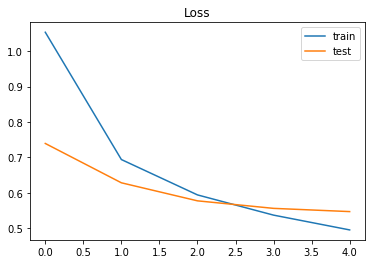

In [22]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

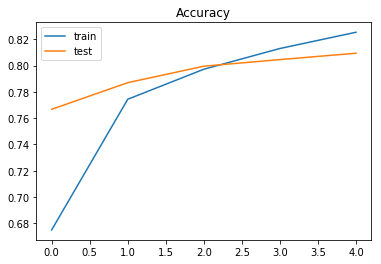

In [23]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

Lets check for with a new sample.

In [24]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_sequence)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

[[2.5737792e-02 1.2240585e-02 3.1925705e-03 6.8739533e-01 2.2442664e-01
  4.0211823e-02 1.2312459e-03 3.0785592e-04 6.7509606e-04 1.4341797e-03
  2.4060376e-03 3.3677297e-04 4.0409900e-04]] Credit card or prepaid card


we can improve the model by using pre-trianed embeddings like glove, etc.. 
You can find the improved model [here](https://github.com/Kalyankr/Insincere-questions-classification)